In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [2]:
val = pd.read_csv("/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/valid_clustered_vf.csv")
test = pd.read_csv("/network/scratch/t/tengmeli/scratch/ecosystem-embedding/training/test_clustered_vf.csv")

In [3]:
geoDatav = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

In [4]:
preds_path = "/network/projects/_groups/ecosystem-embeddings/ebird_checkpoints/resnet18_location_env_400_epochs/preds"

In [5]:
path = "/network/projects/_groups/ecosystem-embeddings/data/hotspot_data/hotspots_june_filtered.csv"
df = pd.read_csv(path)
df = df.drop_duplicates("hotspot_id")

geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)   
gdf["split"] = ""
idx = gdf[gdf["hotspot_id"].isin(list(val["hotspot"]))].index
gdf.loc[idx,"split"] = "val"
idx = gdf[gdf["hotspot_id"].isin(list(test["hotspot"]))].index
gdf.loc[idx,"split"] = "test"

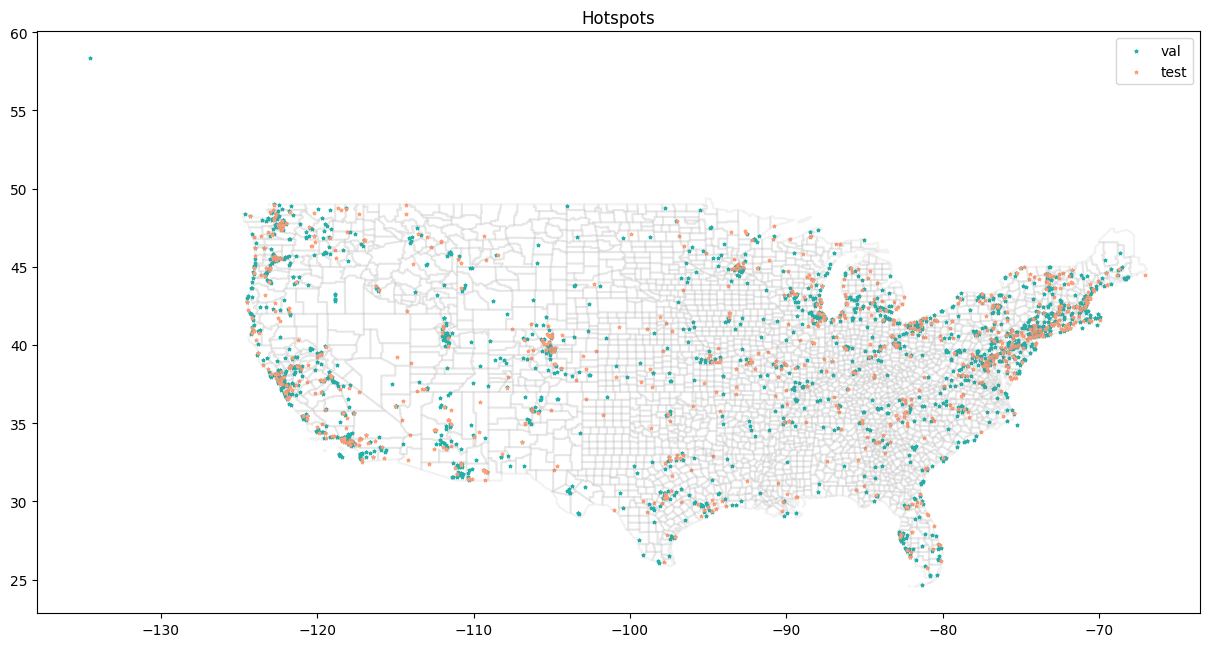

In [50]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
gdf[gdf["split"]=="val"].plot(ax=ax, marker='*', color='lightseagreen', markersize=5, label = "val")
gdf[gdf["split"]=="test"].plot(ax=ax, marker='*', color='lightsalmon', markersize=5, label = "test")

plt.legend()
plt.title("Hotspots")
plt.show()


In [8]:
test_hotspots = test["hotspot"].values
val_hotspots = val["hotspot"].values

In [9]:
preds_files =[os.path.join(preds_path, hs + ".npy") for hs in test_hotspots]

In [10]:
# format predictions as n_samples * features
preds_array = np.zeros((len(preds_files), 379))

In [12]:
hs_list = []
i = 0
for hs in test_hotspots:
    path = os.path.join(preds_path, hs + ".npy") 
    if os.path.exists(path):
        pred = np.load(path)
        hs_list += [path]
        preds_array[i, :] = pred
        i += 1

# t-SNE

In [13]:
import sklearn.manifold 

In [14]:
TSNE = sklearn.manifold.TSNE(n_components=2)

In [15]:
out = TSNE.fit_transform(preds_array)

/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [119]:
TSNE = sklearn.manifold.TSNE(n_components=3)
out3d = TSNE.fit_transform(preds_array)

/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/mila/t/tengmeli/GLC-tf/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [16]:
from PIL import Image

In [17]:
maj_landuse = []
for i, row in test.iterrows():
    a = np.array(Image.open(test["landuse"][i]))
    values, counts = np.unique(a, return_counts=True)
    ind = np.argmax(counts)
    maj_landuse += [values[ind]]

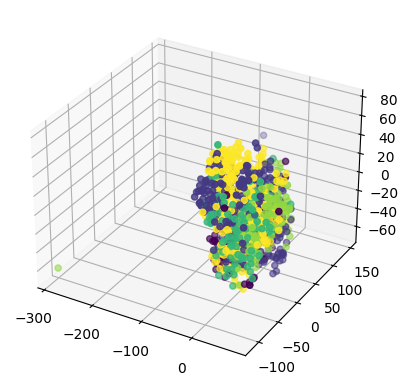

In [121]:

df2 = pd.DataFrame()
df2["comp-1"] = out3d[:,0]
df2["comp-2"] = out3d[:,1]
df2["comp-3"] = out3d[:,2]


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(df2["comp-1"], df2["comp-2"], df2["comp-3"], c = maj_landuse)


In [20]:

df1 = pd.DataFrame()
df1["comp-1"] = out[:,0]
df1["comp-2"] = out[:,1]



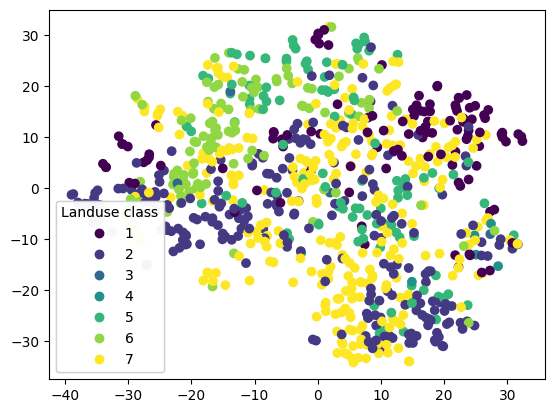

In [19]:


fig, ax = plt.subplots()
scatter = ax.scatter(df1["comp-1"], df1["comp-2"], c=maj_landuse)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Landuse class")
ax.add_artist(legend1)


In [129]:
np.unique(maj_landuse)

array([1, 2, 3, 4, 5, 6, 7], dtype=uint8)


1. Water
Areas where water was predominantly present throughout the year; may not cover areas with sporadic or ephemeral water; contains little to no sparse vegetation, no rock outcrop nor built up features like docks; examples: rivers, ponds, lakes, oceans, flooded salt plains.

2. Trees
Any significant clustering of tall (~15 feet or higher) dense vegetation, typically with a closed or dense canopy; examples: wooded vegetation,  clusters of dense tall vegetation within savannas, plantations, swamp or mangroves (dense/tall vegetation with ephemeral water or canopy too thick to detect water underneath).

3. Grass
Open areas covered in homogenous grasses with little to no taller vegetation; wild cereals and grasses with no obvious human plotting (i.e., not a plotted field); examples: natural meadows and fields with sparse to no tree cover, open savanna with few to no trees, parks/golf courses/lawns, pastures.

4. Flooded vegetation
Areas of any type of vegetation with obvious intermixing of water throughout a majority of the year; seasonally flooded area that is a mix of grass/shrub/trees/bare ground; examples: flooded mangroves, emergent vegetation, rice paddies and other heavily irrigated and inundated agriculture.

5. Crops
Human planted/plotted cereals, grasses, and crops not at tree height; examples: corn, wheat, soy, fallow plots of structured land.

6. Scrub/shrub
Mix of small clusters of plants or single plants dispersed on a landscape that shows exposed soil or rock; scrub-filled clearings within dense forests that are clearly not taller than trees; examples: moderate to sparse cover of bushes, shrubs and tufts of grass, savannas with very sparse grasses, trees or other plants

7. Built Area
Human made structures; major road and rail networks; large homogenous impervious surfaces including parking structures, office buildings and residential housing; examples: houses, dense villages / towns / cities, paved roads, asphalt.

8. Bare ground
Areas of rock or soil with very sparse to no vegetation for the entire year; large areas of sand and deserts with no to little vegetation; examples: exposed rock or soil, desert and sand dunes, dry salt flats/pans, dried lake beds, mines.

9. Snow/Ice
Large homogenous areas of permanent snow or ice, typically only in mountain areas or highest latitudes; examples: glaciers, permanent snowpack, snow fields.
 
10. Clouds
No land cover information due to persistent cloud cover.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


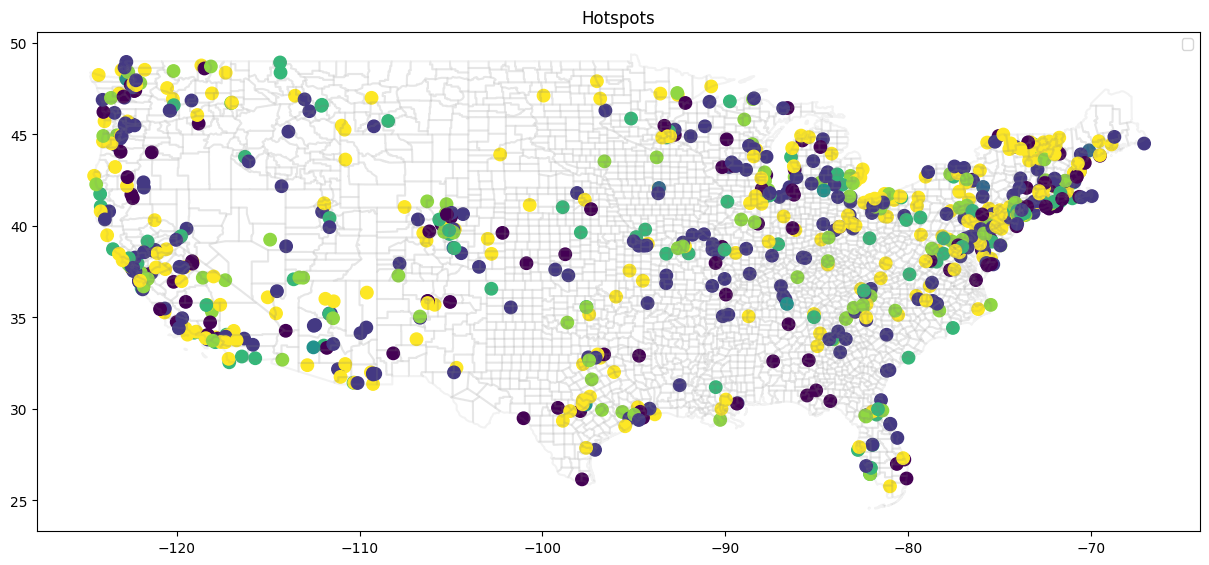

In [84]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=maj_landuse, markersize=80)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()


In [24]:
gdf["maj_landuse"] = 0
test_gdf = gdf[gdf["split"]=="test"].copy()
test_gdf["maj_landuse"] = maj_landuse

# analysis

In [36]:
test_df = test[['hotspot_id', "june_complete_checklists", 'rgb', "species"]]

test_gdf = gdf[gdf["split"]=="test"]

test_df["maj_landuse"] = maj_landuse

test_df = test_df.merge(test_gdf[['hotspot_id', 'lon', 'lat']])

not_songbird_idx = np.load("/network/projects/_groups/ecosystem-embeddings/species_splits/not_songbirds_idx.npy")



test_df["mae"] = 0
test_df["mse"] = 0
test_df["non_zero"] = 0
test_df["topk"] = 0
for i, row in test_df.iterrows():
    preds = np.load(preds_files[i])
    
    with open(row["species"]) as f:
        gt = json.load(f)["probs"]
    gt = np.array(gt)[not_songbird_idx]
    f.close()
    
    test_df.loc[i, "mae"] = np.sum(np.abs(preds - gt))
    test_df.loc[i, "mse"] = np.sum(np.square(preds - gt))
    nonzero = len(np.nonzero(gt)[0])
    if nonzero != 0 :
        test_df.loc[i,"non_zero"] = nonzero
    
        indices_pred = (-preds).argsort()[:nonzero]
        indices_gt = np.nonzero(gt)[0]

        test_df.loc[i,"topk"] = len([a for a in indices_pred if a in indices_gt])/nonzero
    else:
        test_df.loc[i,"topk"] = -1
    


/tmp/ipykernel_1019441/1177551245.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["maj_landuse"] = maj_landuse


In [38]:
test_df.to_csv("preds.csv")

In [62]:
test_df["preds_"] = 7

In [63]:
test_df.loc[test_df["topk"]<0.85,"preds_"]  = 6
test_df.loc[test_df["topk"]<0.75,"preds_"]  = 5
test_df.loc[test_df["topk"]<0.65,"preds_"]  = 4
test_df.loc[test_df["topk"]<0.55,"preds_"]  = 3
test_df.loc[test_df["topk"]<0.45,"preds_"]  = 2
test_df.loc[test_df["topk"]==-1,"preds_"]  = 0
test_df.loc[test_df["topk"]==0,"preds_"]  = 1

In [ ]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Landuse class")
ax.add_artist(legend1)

In [71]:
test_df["preds_"]= test_df["preds_"]/6

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


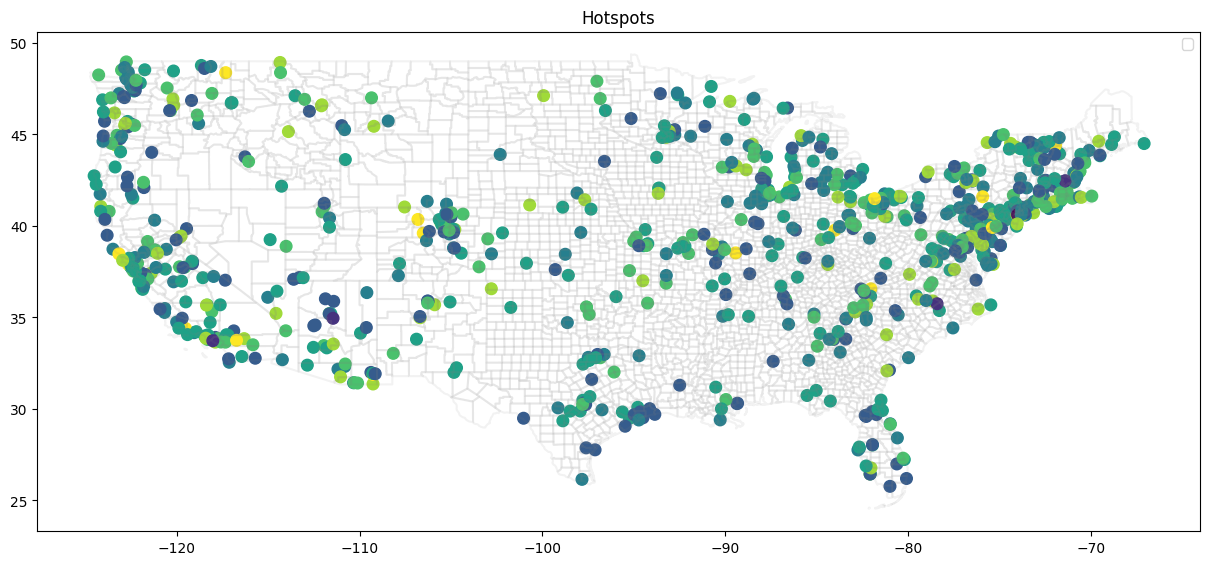

In [85]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
test_gdf.plot(ax=ax, marker='o', c=test_df["preds_"], markersize=70, legend = True)#, label = legend1)

plt.legend()
plt.title("Hotspots")
plt.show()

In [80]:
gdf[gdf["split"]=="test"].merge(test_df)

,Unnamed: 0,hotspot_id,lon,lat,county,county_code,state,state_code,june_complete_checklists,num_checklists,...,geometry,split,maj_landuse,rgb,species,mae,mse,non_zero,topk,preds_


In [83]:
gdf[gdf["split"]=="test"].merge(test_df)

,Unnamed: 0,hotspot_id,lon,lat,county,county_code,state,state_code,june_complete_checklists,num_checklists,...,geometry,split,maj_landuse,rgb,species,mae,mse,non_zero,topk,preds_


In [90]:
tt = test_gdf.merge(test_df[["hotspot_id","mae","mse", "topk", "preds_"]], left_on = "hotspot_id",right_on = "hotspot_id")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


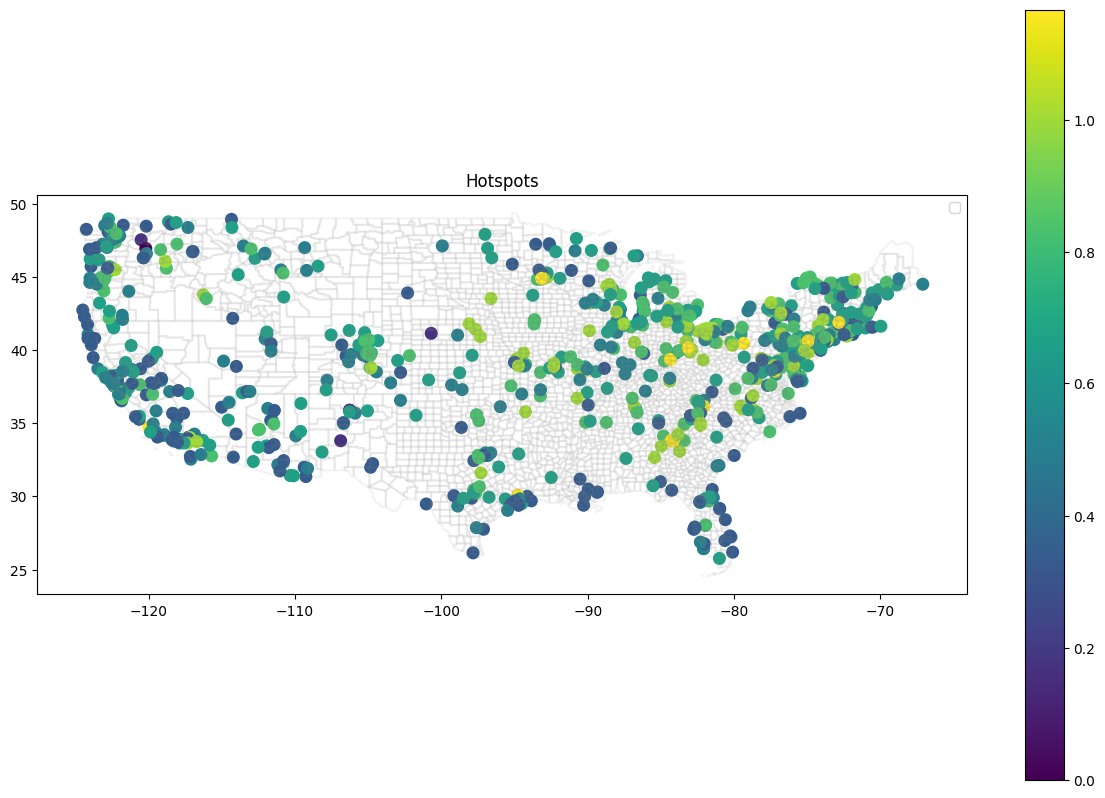

In [93]:
fig, ax = plt.subplots(figsize =(15,10))
#train_gdf.drop_duplicates(["geometry"]).boundary.plot(ax = ax, alpha = 0.4, edgecolor = "gray")
geoDatav[~geoDatav["STATE"].isin([ "02","15", "72"])].boundary.plot(ax=ax, alpha = 0.1, edgecolor = "gray" )
#gdf[gdf["split"]=="train"].plot(ax=ax,marker='*', color='yellowgreen', markersize=5, label = "train")
tt.plot(ax=ax, column ="preds_", marker='o', c=tt["preds_"], markersize=70, legend= True)

plt.legend()
plt.title("Hotspots")
plt.show()

<AxesSubplot:>

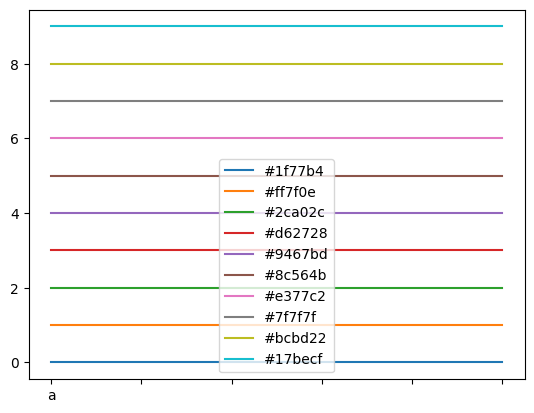

In [94]:
import matplotlib.pyplot as plt
pd.DataFrame(columns=plt.rcParams['axes.prop_cycle'].by_key()['color']).T.assign(a=range(10),b=range(10)).T.plot()
